<a href="https://colab.research.google.com/github/Dataengineer2002/Rotten_Tomatoes/blob/main/Rotten_tomatoes_rating1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [34]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

#Data Loading and Exploring

In [25]:
# Load the Rotten Tomatoes dataset

df = pd.read_excel('/content/Rotten_Tomatoes_Movies3.xls')

# Displaying basic information about the dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

#Data Preprocessing

In [26]:
# =============================
# 3. Data Preprocessing
# =============================
# 3.1 Drop columns that are unlikely to affect audience rating (like movie_title)
columns_to_drop = ['movie_title', 'movie_info', 'critics_consensus', 'directors', 'writers', 'cast', 'studio_name']
df.drop(columns=columns_to_drop, axis=1, inplace=True)


In [27]:
# 3.2 Handle missing values
# Fill numerical columns with median and categorical columns with mode
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col].fillna(df[col].median(), inplace=True)
    elif df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-27-40ace2d65170>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-27-40ace2d65170>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [28]:
# 3.3 Convert date columns to numerical format (extract year)
df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'], errors='coerce').dt.year
df['on_streaming_date'] = pd.to_datetime(df['on_streaming_date'], errors='coerce').dt.year

# Fill NaNs from date extraction with the median year
df['in_theaters_date'].fillna(df['in_theaters_date'].median(), inplace=True)
df['on_streaming_date'].fillna(df['on_streaming_date'].median(), inplace=True)

<ipython-input-28-b0b6ee0c0026>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['in_theaters_date'].fillna(df['in_theaters_date'].median(), inplace=True)
<ipython-input-28-b0b6ee0c0026>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [29]:
# 3.4 Encode categorical columns
categorical_columns = ['rating', 'genre', 'tomatometer_status']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [30]:
# 3.5 Separate features (X) and target (y)
X = df.drop('audience_rating', axis=1)
y = df['audience_rating']

In [31]:
# 3.6 Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# 3.7 Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (13310, 1093)
Test data shape: (3328, 1093)


#Build Neural Network

In [35]:
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)  # Single output for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create model under TPU strategy for faster training
with strategy.scope():
    model = create_model(X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Neural Network Training

*  Epoch
*  Cross Validation



In [36]:
# ===========================
# 5. Train the Neural Network
# ===========================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,  # Large batch size for TPU
    verbose=1
)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 2544.3738 - mae: 43.8186 - val_loss: 274.2610 - val_mae: 12.8115
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 381.4935 - mae: 14.7153 - val_loss: 225.5496 - val_mae: 11.9973
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 286.5445 - mae: 13.3214 - val_loss: 220.0740 - val_mae: 11.8258
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273.5829 - mae: 13.0767 - val_loss: 218.5958 - val_mae: 11.7827
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 261.7145 - mae: 12.8358 - val_loss: 220.3280 - val_mae: 11.8317
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 251.1323 - mae: 12.6348 - val_loss: 232.6871 - val_mae: 12.2359
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 251.6768 - mae: 12.5094 - val_loss: 222.0868 - val_mae: 11.8672
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 241.6594 - mae: 12.3350 - val_loss: 223.3477 - val_mae: 11.9638
Epoch 

#Model Evaluation

In [49]:
# Predict on test data

import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=8, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R2: {r2_xgb}")

XGBoost MSE: 188.5487863203502
XGBoost MAE: 10.878150652234371
XGBoost R2: 0.537826640902087


# 7. Visualization



In [50]:
# 7.1 Tabular View of Predictions (First 10 Rows)
results_df = pd.DataFrame({
    'Index': range(10),
    'Actual Rating': y_test.values[:10],
    'Predicted Rating': y_pred[:10].flatten()
})
print(results_df)

   Index  Actual Rating  Predicted Rating
0      0           44.0         43.312168
1      1           41.0         42.050373
2      2           72.0         50.519539
3      3           87.0         67.870285
4      4           90.0         65.530502
5      5           64.0         53.837158
6      6           39.0         44.560505
7      7           92.0         54.813496
8      8           56.0         58.396397
9      9           46.0         47.862011


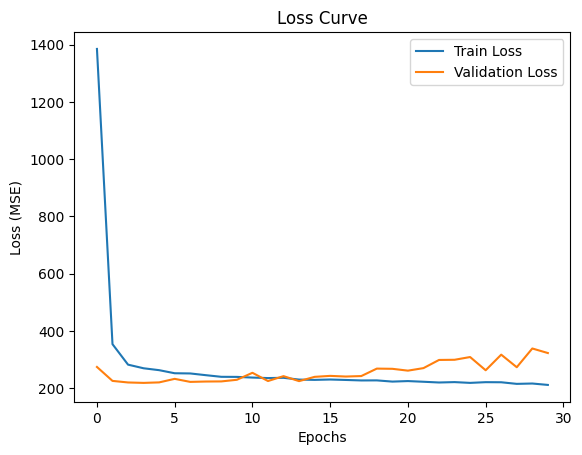

In [51]:
# 7.2 Plot Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curve')
plt.legend()
plt.show()

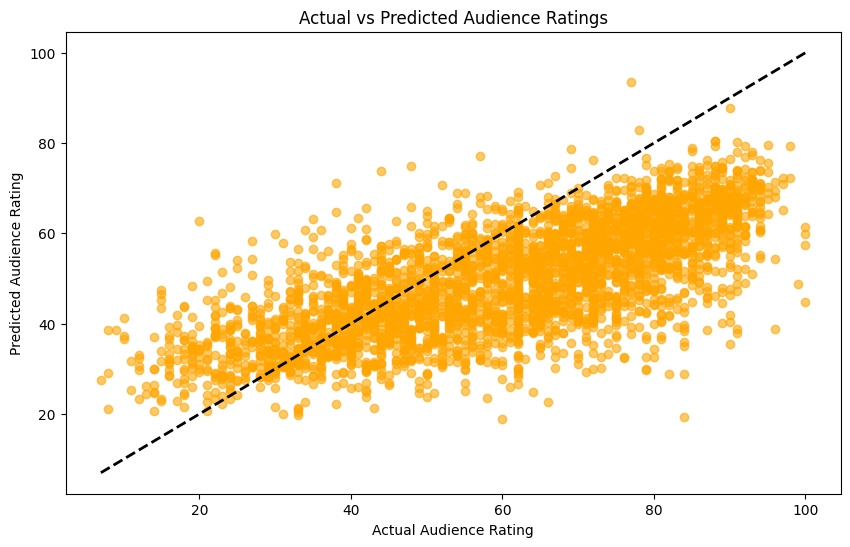

In [52]:
# 7.3 Plot Actual vs Predicted Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Audience Rating')
plt.ylabel('Predicted Audience Rating')
plt.title('Actual vs Predicted Audience Ratings')
plt.show()